# Pre-Fit and Post-Fit plots
This notebook plots the pre/post-fit plots using the outputs from running runcards.py and runcombine.py. Firstly, make a `fitDiagnostics.root` file containin the pre/post-fit distributions by activating cmsenv and running 

`combine -M FitDiagnostics cards-GluGluToSUEP_HT1000_T2p00_mS700.000_mPhi2.000*/combined.root -m 200 --rMin -1 --rMax 2 --saveShapes`

Note that any other datacard is also fine and should give the same prefit and background only postfit distributions, but make sure to adjust the r-interval (--rMin, --rMax) accordingly.


{'fit_s': array([4.26738477e+03, 1.98556412e+02, 1.76458092e+01, 4.18955125e-07]), 'prefit': array([4267.41162109,  198.5868988 ,   17.65216827,    0.        ])}
{'fit_s': array([6.62221756e+01, 1.63517532e+01, 4.87686491e+00, 8.14321276e-04]), 'prefit': array([677.72692871, 115.64617157,  39.90235519,   0.        ])}


/tmp/ipykernel_256418/3903459859.py:67: RuntimeWarning: divide by zero encountered in true_divide
  ratio_prefit = np.divide(data, expected['prefit'], out=np.ones_like(data), where=data!=0) #Overestimate
/tmp/ipykernel_256418/3903459859.py:71: RuntimeWarning: divide by zero encountered in power
  prefit_err = np.sqrt( ((data**2)*(expected['prefit']**-4))*(expected_err['prefit']**2) + (expected['prefit']**-2)*(data))
/tmp/ipykernel_256418/3903459859.py:71: RuntimeWarning: invalid value encountered in multiply
  prefit_err = np.sqrt( ((data**2)*(expected['prefit']**-4))*(expected_err['prefit']**2) + (expected['prefit']**-2)*(data))


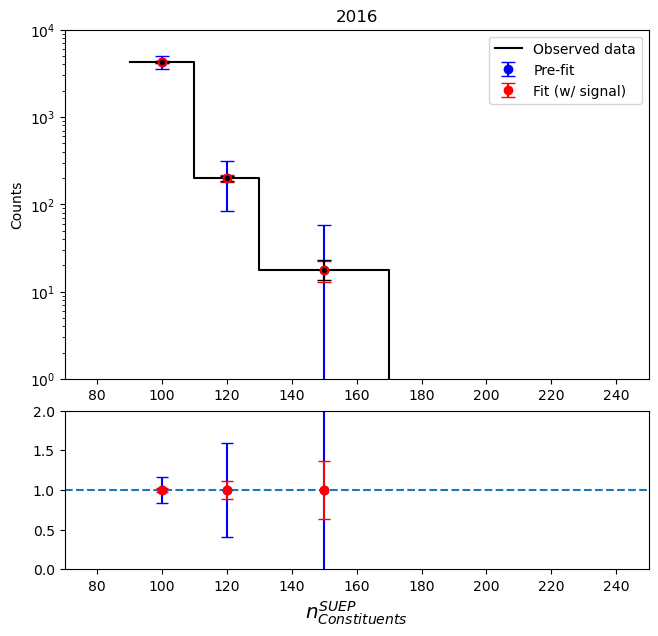

{'fit_s': array([5.70434570e+03, 2.80394348e+02, 6.83530283e+00, 4.97406241e-08]), 'prefit': array([5704.39111328,  280.43170166,    6.8397975 ,    0.        ])}
{'fit_s': array([7.58065262e+01, 1.99030857e+01, 3.99959493e+00, 3.18000850e-04]), 'prefit': array([1183.18859863,  224.15507507,   13.09789848,    0.        ])}


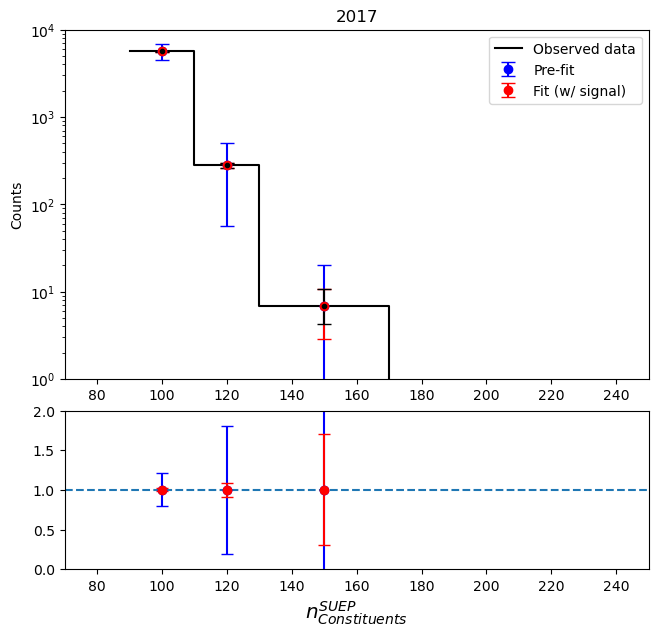

{'fit_s': array([7.07537207e+03, 3.43422333e+02, 1.10735760e+01, 4.32371166e-07]), 'prefit': array([7075.26708984,  343.45956421,   11.07934093,    0.        ])}
{'fit_s': array([8.28843231e+01, 2.24162636e+01, 6.49765873e+00, 7.41219148e-04]), 'prefit': array([1105.46240234,  169.26356506,   30.58812141,    0.        ])}


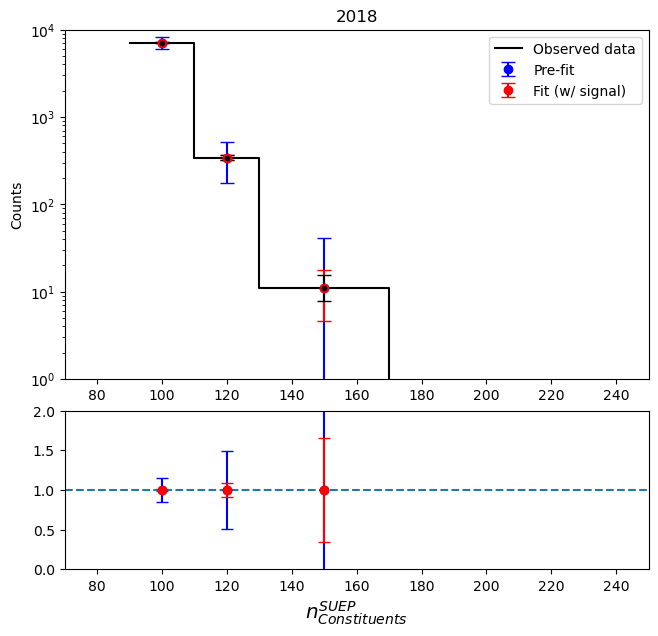

In [10]:
import uproot
import numpy as np
import matplotlib.pyplot as plt
import hist.intervals
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import chi2

filename = "../FlatYears/cards-GluGluToSUEP_HT1000_T3p00_mS300.000_mPhi3.000_T3.000_modegeneric_TuneCP5_13TeV-pythia8/fitDiagnostics_t0.root"  # replace with your actual ROOT file path
file = uproot.open(filename)

bins = np.array([90,110,130,170,500])
centers = np.array( [(bins[i] + bins[i + 1])/2 for i in range(len(bins) - 1)])

def compute_poisson_interval(values, confidence=0.6827):
    alpha = 1 - confidence
    low = chi2.ppf(alpha / 2., 2 * values) / 2
    high = chi2.ppf(1. - alpha / 2., 2 * (values + 1)) / 2
    return low, high


for year in ['2016','2017','2018']:
    
    ### Collect data
    expected, expected_err = {}, {}
    for fit in ['fit_s','prefit']: #fit_s 
        
        expected[fit] = np.array([]) 
        expected_err[fit] = np.array([])

        for sig_bins in ['Bin1Sig','Bin2Sig','Bin3Sig','Bin4Sig']: #['Bin0crF','Bin1crF','Bin2crF','Bin3crF','Bin4crF']

            name = 'shapes_{}/{}{};1'.format(fit,sig_bins,year)
            err = np.sqrt(file[name]['total_covar;1'].to_numpy()[0][0][0])
            expected[fit] = np.append(expected[fit],file[name]['expected;1'].values()[0])
            expected_err[fit] = np.append(expected_err[fit],err)
              
    data = np.array([])
    for sig_bins in ['Bin1Sig','Bin2Sig','Bin3Sig','Bin4Sig']:
        name = 'shapes_{}/{}{};1'.format(fit,sig_bins,year)
        data = np.append(data,file[name]['data;1'].values()[1])
        
    print(expected)
    print(expected_err)
            
    ### Plot everything
    plt.figure(figsize=(8,10))
    plt.gcf().subplots_adjust(bottom=0.15, left=0.17)

    # Plot histograms
    ax1 = plt.subplot2grid((4,1), (0,0),rowspan=2)
    ax1.errorbar(centers, expected['prefit'],label='Pre-fit',yerr=expected_err['prefit'], fmt='o', capsize=5,c='b')
    ax1.errorbar(centers, expected['fit_s'],label='Fit (w/ signal)',yerr=expected_err['fit_s'], fmt='o', capsize=5,c='r')
    low, high = compute_poisson_interval(data) #the pre-fit distribution
    ax1.errorbar(centers, data,yerr=[data-low,high-data], fmt='.',c='black', capsize=5)
    ax1.step(bins, np.append(data,0),where='post',c='black',label='Observed data')

    ax1.set_title(year)
    ax1.set_ylabel("Counts")
    ax1.set_yscale('log')
    ax1.set_ylim(1e0, 1e4)
    ax1.legend()

    # Plot ratios
    ax2 = plt.subplot2grid((4,1), (2,0),sharex=ax1)

    ratio_prefit = np.divide(data, expected['prefit'], out=np.ones_like(data), where=data!=0) #Overestimate
    ratio_fit_b = np.divide(data, expected['fit_s'], out=np.ones_like(data), where=data!=0) #Overestimate

    #Calculate errors
    prefit_err = np.sqrt( ((data**2)*(expected['prefit']**-4))*(expected_err['prefit']**2) + (expected['prefit']**-2)*(data))
    fit_b_err = np.sqrt( ((data**2)*(expected['fit_s']**-4))*(expected_err['fit_s']**2) + (expected['fit_s']**-2)*(data))

    ax2.errorbar(centers, ratio_prefit,fmt='o', color='b', label = 'Pre-fit',yerr= prefit_err,capsize=4)
    ax2.errorbar(centers, ratio_fit_b,fmt='o', color='r', label = 'Fit (w/ signal)',yerr= fit_b_err,capsize=4)
    ax2.axhline(1,ls='--')
    ax2.set_xlim([70,250])
    ax2.set_ylim([0,2])
    ax2.set_xlabel(r"$n^{SUEP}_{Constituents}$", fontsize='x-large')

    # plt.savefig("/home/submit/pvanstee/public_html/SUEP/closure_uncertainties/{}".format(year))
    plt.show()

In [79]:
compute_poisson_interval(0, confidence=0.999999426696856)

(nan, 15.06499839344673)